In [1]:
# %load crypto_pred_pract.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

# load dataset with singling out the rows with desired crypto
df = pd.read_csv(r'C:\Users\Administrator\Desktop\datasets\crypto\crypto-markets.csv')
df = df.loc[df['name'] == 'Bitcoin']

# basic exploration for data organization and possible noise
df.columns

Index(['slug', 'symbol', 'name', 'date', 'ranknow', 'open', 'high', 'low',
       'close', 'volume', 'market', 'close_ratio', 'spread'],
      dtype='object')

In [9]:
df.head(10)

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread
0,bitcoin,BTC,Bitcoin,2013-04-28,1,135.30,135.98,132.10,134.21,0.0,1.500520e+09,0.5438,3.88
1,bitcoin,BTC,Bitcoin,2013-04-29,1,134.44,147.49,134.00,144.54,0.0,1.491160e+09,0.7813,13.49
2,bitcoin,BTC,Bitcoin,2013-04-30,1,144.00,146.93,134.05,139.00,0.0,1.597780e+09,0.3843,12.88
3,bitcoin,BTC,Bitcoin,2013-05-01,1,139.00,139.89,107.72,116.99,0.0,1.542820e+09,0.2882,32.17
4,bitcoin,BTC,Bitcoin,2013-05-02,1,116.38,125.60,92.28,105.21,0.0,1.292190e+09,0.3881,33.32
5,bitcoin,BTC,Bitcoin,2013-05-03,1,106.25,108.13,79.10,97.75,0.0,1.180070e+09,0.6424,29.03
6,bitcoin,BTC,Bitcoin,2013-05-04,1,98.10,115.00,92.50,112.50,0.0,1.089890e+09,0.8889,22.50
7,bitcoin,BTC,Bitcoin,2013-05-05,1,112.90,118.80,107.14,115.91,0.0,1.254760e+09,0.7521,11.66
8,bitcoin,BTC,Bitcoin,2013-05-06,1,115.98,124.66,106.64,112.30,0.0,1.289470e+09,0.3141,18.02
9,bitcoin,BTC,Bitcoin,2013-05-07,1,112.25,113.44,97.70,111.50,0.0,1.248470e+09,0.8767,15.74


In [12]:
df.isnull().any()

slug           False
symbol         False
name           False
date           False
ranknow        False
open           False
high           False
low            False
close          False
volume         False
market         False
close_ratio    False
spread         False
dtype: bool

In [3]:
# dropping columns that will have little or counterproductive effect on the process
df = df.drop(['symbol', 'slug', 'ranknow', 'spread', 'close_ratio'], 1)
df.columns

Index(['name', 'date', 'open', 'high', 'low', 'close', 'volume', 'market'], dtype='object')

In [4]:
df.describe()

,open,high,low,close,volume,market
count,1866.000000,1866.000000,1866.000000,1866.000000,1.866000e+03,1.866000e+03
mean,1885.744502,1951.660102,1812.283730,1889.513762,1.171548e+09,3.078214e+10
std,3321.359095,3458.838432,3153.471445,3323.418678,3.023214e+09,5.621236e+10
min,68.500000,74.560000,65.530000,68.430000,0.000000e+00,7.792550e+08
25%,284.857500,291.127500,280.985000,285.310000,1.726688e+07,4.051458e+09
50%,565.950000,576.295000,535.000000,565.975000,4.917735e+07,7.290880e+09
75%,1055.210000,1094.930000,1034.742500,1059.617500,2.448032e+08,1.696472e+10
max,19475.800000,20089.000000,18974.100000,19497.400000,2.384090e+10,3.261410e+11


In [5]:
# setting up date column as the index for time series
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df.head()

,name,open,high,low,close,volume,market
date,,,,,,,
2013-04-28,Bitcoin,135.30,135.98,132.10,134.21,0.0,1.500520e+09
2013-04-29,Bitcoin,134.44,147.49,134.00,144.54,0.0,1.491160e+09
2013-04-30,Bitcoin,144.00,146.93,134.05,139.00,0.0,1.597780e+09
2013-05-01,Bitcoin,139.00,139.89,107.72,116.99,0.0,1.542820e+09
2013-05-02,Bitcoin,116.38,125.60,92.28,105.21,0.0,1.292190e+09


In [8]:
# selecting the beginning date of relevant data, adding some features, dropping other
df = df['2017-01-01':]
df['daily_avg'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
df['hilo'] = (df['high'] - df['close']) / df['close'] * 100

# adding rolling average feature, taken from previous 6 entries, filling in NaN
df_rolling_avg = df['close']
df_rolling_avg = df_rolling_avg.rolling(window=6).mean()
df_rolling_avg = df_rolling_avg.rename('rolling_avg', inplace=True)
df = pd.concat([df, df_rolling_avg],1)
df = df.fillna(method='backfill')

# check for autocorrelation without seaborn graph
print("====== Autocorrelation ======")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df.corr())

====== Autocorrelation ======
                 open      high       low     close    market  daily_avg  \
open         1.000000  0.997766  0.995981  0.994810  0.999929   0.998371   
high         0.997766  1.000000  0.996252  0.998297  0.997517   0.999335   
low          0.995981  0.996252  1.000000  0.997421  0.996111   0.998570   
close        0.994810  0.998297  0.997421  1.000000  0.994684   0.998850   
market       0.999929  0.997517  0.996111  0.994684  1.000000   0.998287   
daily_avg    0.998371  0.999335  0.998570  0.998850  0.998287   1.000000   
hilo         0.230338  0.218447  0.181245  0.173893  0.229017   0.201714   
rolling_avg  0.995305  0.994122  0.992006  0.991609  0.995437   0.994492   
rolling_avg  0.995305  0.994122  0.992006  0.991609  0.995437   0.994492   
rolling_avg  0.995305  0.994122  0.992006  0.991609  0.995437   0.994492   

                 hilo  rolling_avg  rolling_avg  rolling_avg  
open         0.230338     0.995305     0.995305     0.995305  
high   

In [9]:
# importing sklearn ML modules
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, BayesianRidge, ElasticNetCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

# shifting data to make space for a 3 months worth forecast, splitting for training
df['forecast'] = df['daily_avg'].shift(-90)
X = df.dropna().drop(['forecast'], axis=1)
y = df.dropna()['forecast']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)
forecast =  df.tail(90).drop(['forecast'], 1)

# rescaling data
scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)

# list of lists with models to be tested
classifiers = [['LinReg: ', LinearRegression()],
               ['RF Reg: ', RandomForestRegressor(n_estimators=100)],
               ['BayesR: ', BayesianRidge()],
               ['ExTReg: ', ExtraTreesRegressor(n_estimators=200, min_samples_split=5)],
               ['ENetCV: ', ElasticNetCV()]]

# printing tested models' accuracy with root mean squared error and r squared
print("====== RMSE ======")
for name,classifier in classifiers:
    classifier = classifier
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_test)
    print(name, ("% .2f" % np.sqrt(mean_squared_error(y_test, predictions))))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


====== RMSE ======
LinReg:   3374.66
RF Reg:   1592.58
BayesR:   3407.71
ExTReg:   1582.18
ENetCV:   3362.29


In [10]:
print("====== R^2 ======")
for name,classifier in classifiers:
    print(name, ("% .2f" % classifier.score(X_test, y_test)))

====== R^2 ======
LinReg:   0.25
RF Reg:   0.83
BayesR:   0.24
ExTReg:   0.84
ENetCV:   0.26


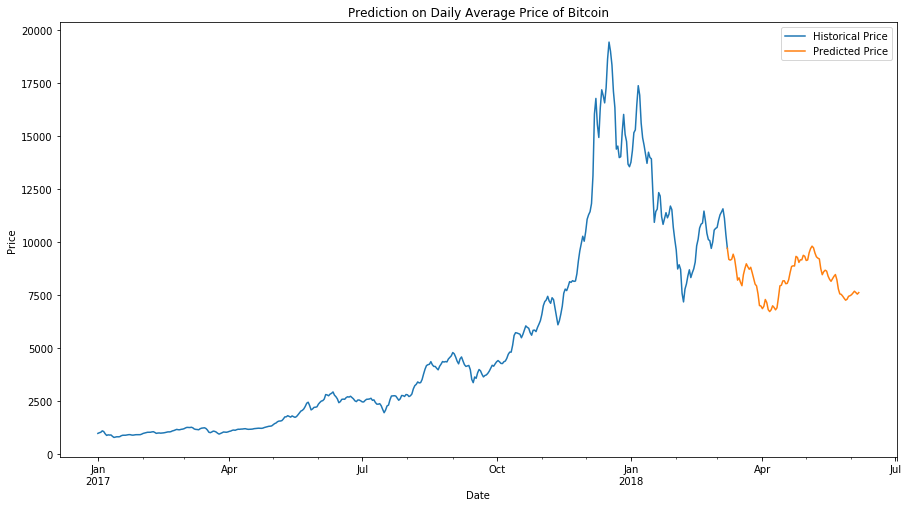

In [11]:
# picking and using the best performing model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# predicting with the best performing model
predict = model.predict(forecast)

# plotting the results into a graph
plt.figure(figsize=(15,8))
(df[:-90]['daily_avg']).plot(label='Historical Price')
(df[-91:]['daily_avg']).plot(label='Predicted Price')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Prediction on Daily Average Price of Bitcoin')
plt.legend()
plt.show()

{
  "shell_port": 53494,
  "iopub_port": 53495,
  "stdin_port": 53496,
  "control_port": 53497,
  "hb_port": 53498,
  "ip": "127.0.0.1",
  "key": "5d2195d2-212d7f128f7e320d7311d896",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-a86dc0a4-6a39-4854-83ad-b0ef5ce59fdd.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
